In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat



def mp(P, M, xn):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                XX[l-M-1, ((p-1)*(M+1))+m] = (np.abs(xn[l-m])**(2*p-2)*(xn[l-m]))[0]
    return XX

def readeq(val, precision):
    return np.floor(val / (2 ** precision))

def extract_coefficients(in_ext,out_ext,M, P):
    XX_ext = mp(P, M, in_ext)
    N = abs(out_ext.shape[0]-XX_ext.shape[0])
    coefficients, _, _, _ = np.linalg.lstsq(XX_ext, out_ext[N:], rcond=None)
    return XX_ext, coefficients

def mp_int(P, M, xn, bits):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                    A = np.real(xn[l-m])[0]
                    B = np.imag(xn[l-m])[0]
                    modulo_power = 2**bits 
                    modulo_square = readeq(A ** 2 + B ** 2, bits)
                    for _ in range(1, p):
                       modulo_power = readeq(modulo_power * modulo_square, bits)
                    real_part = readeq(A * modulo_power,bits)
                    imag_part = readeq(B * modulo_power,bits)
                    XX[l-M-1, ((p-1)*(M+1))+m] = complex(real_part,imag_part)        
    return XX

def MultiplicadorMatrizes(coefficients, XX, precision):
    max_value = 0  
    coefficients = np.round(coefficients *(2**precision))
    result = np.zeros_like(XX, dtype=np.complex128)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            
            A = np.real(coefficients[j,0])
            B = np.imag(coefficients[j,0])
            C = np.real(XX[i, j])
            D = np.imag(XX[i, j])

            readequated_real = readeq(A * C - B * D, precision)
            readequated_imag = readeq(A * D + B * C, precision)

            max_value = max(max_value, readequated_real)
            max_value = max(max_value, readequated_imag)
            
            result[i, j] = complex(readequated_real, readequated_imag) 

    soma_filas = np.sum(result, axis=1).reshape(-1, 1)

    extra_bits = np.ceil(np.log2(max_value + 1))
    
    return soma_filas, extra_bits

def Calculo_do_modelo(P,M,p_bits,in_val_norm,out_val_norm,coefficients):
    in_val_fixed = np.round(in_val_norm * (2 ** p_bits)) 
    out_val_fixed = np.round(out_val_norm * (2 ** p_bits))
    XX_val = mp_int(P, M, in_val_fixed, p_bits)
    predicted_val_fixed, e_bits = MultiplicadorMatrizes(coefficients, XX_val, p_bits)
    nmse_fixed = nmse_calculo(predicted_val_fixed,out_val_fixed, M)
    # Levar em consideração os bits extras para evitar overflow
    total_bits = p_bits + 1 + e_bits
    return p_bits,e_bits, total_bits, nmse_fixed, in_val_fixed,out_val_fixed,predicted_val_fixed

nmse_calculo = lambda predicted_val, data_out, M:10 * np.log10(np.mean(np.abs(data_out[M:] - predicted_val) ** 2) / np.mean(np.abs(data_out[M:]) ** 2))


In [2]:
# carregar arquivo .mat
mat = loadmat('in_out_SBRT2_direto.mat')

in_data_ext = mat['in_extraction']
out_data_ext = mat['out_extraction']
in_data_val = mat['in_validation']
out_data_val = mat['out_validation']


lista = [in_data_ext, out_data_ext, in_data_val, out_data_val]

modulos = []
for i in lista:
    modulos.append(max(i.imag))
    modulos.append(max(i.real))

maior_modulo = max(modulos)

in_ext_norm  = in_data_ext / maior_modulo
out_ext_norm = out_data_ext /maior_modulo
in_val_norm  = in_data_val/maior_modulo
out_val_norm = out_data_val/maior_modulo

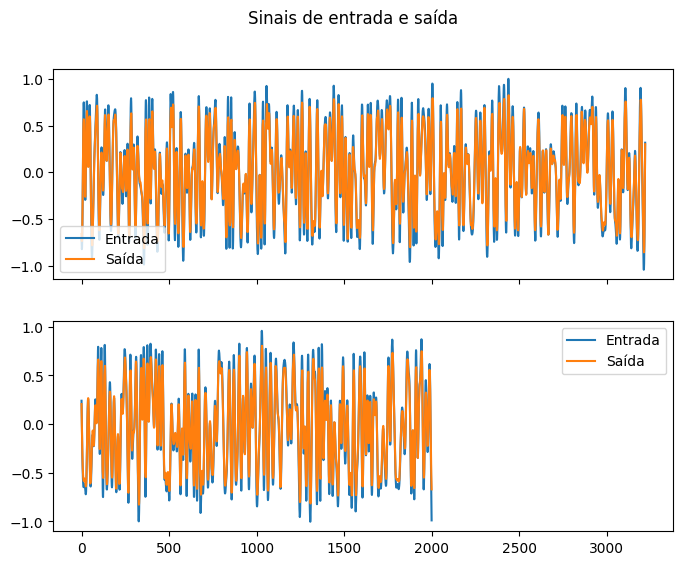

In [3]:
# plotar sinais de entrada e saída
x_ext = range(len(in_data_ext))
x_val = range(len(in_data_val))

fig, axs = plt.subplots(2, sharex=True, figsize=(8, 6))
fig.suptitle('Sinais de entrada e saída')
axs[0].plot(x_ext, np.real(in_ext_norm), label='Entrada')
axs[0].plot(x_ext, np.real(out_ext_norm), label='Saída')
axs[0].legend()
axs[1].plot(x_val, np.real(in_val_norm), label='Entrada')
axs[1].plot(x_val, np.real(out_val_norm), label='Saída')
axs[1].legend()
# tikzplotlib.save("grafico.tex")

plt.show()

In [4]:
M = 3
P = 5

# calculo dos coeficientes do modelo do PA
XX_ext_PA, coefficients_PA_float = extract_coefficients(in_data_ext,out_data_ext,M, P)
# Saida estimada do modelo do PA
predicted_ext_PA = XX_ext_PA @ coefficients_PA_float

# Calculo do modelo do pre-distorcedor
XX_ext_pre, coefficients_DPD_float = extract_coefficients(predicted_ext_PA,in_data_ext, M, P)
# Saida estimada do modelo do predistorcedor
predicted_ext_pre = XX_ext_pre @ coefficients_DPD_float

# saida estimada da cascata
XX_val_PA = mp(P, M, in_data_val)
predicted_val_PA = XX_val_PA @ coefficients_DPD_float

XX_val_DPD = mp(P, M, predicted_val_PA)
predicted_val_DPD = XX_val_DPD @ coefficients_PA_float

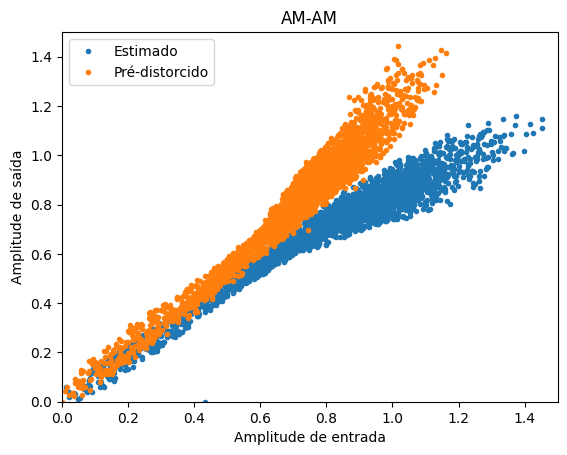

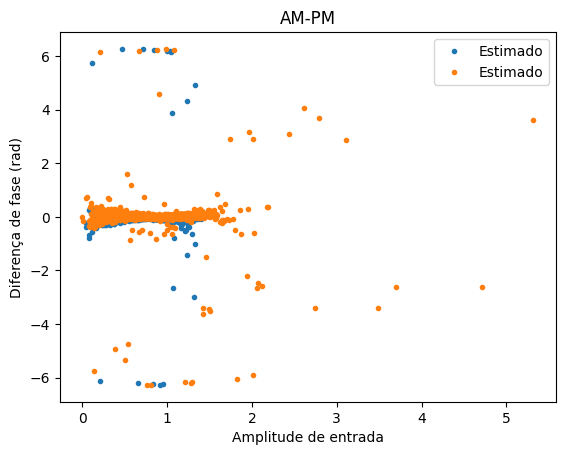

In [5]:
# Gráficos AM-AM e AM-PM
plt.figure()
# plt.plot(np.abs(in_val_fixed[M:]), np.abs(out_val_fixed[M:]), '.', label='Medido')
plt.plot(np.abs(in_data_ext[M:]), np.abs(predicted_ext_PA), '.', label='Estimado')
plt.plot(np.abs(predicted_ext_PA[M:]), np.abs(predicted_ext_pre), '.', label='Pré-distorcido')
# plt.plot(np.abs(in_data_val[M*2:]), np.abs(predicted_val_pre_2), '.', label='Saida'  )
plt.xlim([0, 1.5])
plt.ylim([0, 1.5])

plt.xlabel('Amplitude de entrada')
plt.ylabel('Amplitude de saída')
plt.title('AM-AM')
plt.legend()

plt.figure()
# plt.plot(np.abs(in_val_fixeMd[M:]), np.angle(out_val_fixed[M:])-np.angle(in_val_fixed[M:]), '.', label='Medido')
plt.plot(np.abs(in_data_val[M:]), np.angle(predicted_val_PA)-np.angle(in_data_val[M:]), '.', label='Estimado')
plt.plot(np.abs(predicted_val_PA[M:]), np.angle(predicted_val_DPD)-np.angle(predicted_val_PA[M:]), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Diferença de fase (rad)')
plt.title('AM-PM')
plt.legend()
plt.show()

In [7]:
XX_ext_pa = mp(P, M, in_ext_norm)
coefficients_norm_pa, _, _, _ = np.linalg.lstsq(XX_ext_pa, out_ext_norm[M:], rcond=None)


# Calculo dos coeficientes do modelo do pre-distorcedor
XX_ext_pre = mp(P, M, predicted_ext_PA)
coefficients_norm_pre, _, _, _ = np.linalg.lstsq(XX_ext_pre , in_ext_norm[M*2:], rcond=None)

C:\Users\Je\AppData\Local\Temp\ipykernel_2880\4191430033.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


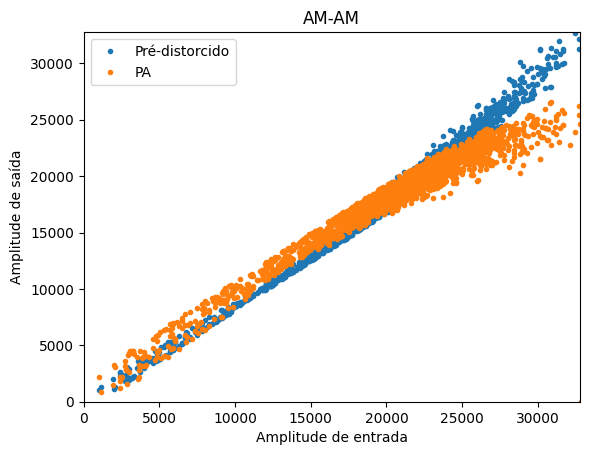

In [40]:
M = 1
P = 2
p_bits = 15
# normalização
in_val_fixed = np.round(in_val_norm * (2 ** p_bits)) 
out_val_fixed = np.round(out_val_norm * (2 ** p_bits))
in_ext_fixed = np.round(in_ext_norm * (2 ** p_bits)) 
out_ext_fixed = np.round(out_ext_norm * (2 ** p_bits))

# calculo dos coeficientes do modelo do PA


predicted_val_ext = XX_ext_pa @ coefficients_norm_pa

# modelo do PA
XX_val_PA = mp_int(P, M, in_val_fixed, p_bits)
predicted_val_fixed_PA, e_bits = MultiplicadorMatrizes(coefficients_norm_pa, XX_val_PA, p_bits)

# modelo do predistocedor
XX_val_pre = mp_int(P, M, in_val_fixed, p_bits)
predicted_val_fixed_pre, e_bits = MultiplicadorMatrizes(coefficients_norm_pre, XX_val_pre, p_bits)

fig, ax = plt.subplots()
ax.plot(np.abs(in_val_fixed[M:]), np.abs(predicted_val_fixed_pre), '.', label='Pré-distorcido')
ax.plot(np.abs(in_val_fixed[M:]), np.abs(predicted_val_fixed_PA), '.', label='PA')
ax.set_xlim([0, 2 ** p_bits])
ax.set_ylim([0, 2 ** p_bits])

ax.set_xlabel('Amplitude de entrada')
ax.set_ylabel('Amplitude de saída')
ax.set_title('AM-AM')
ax.legend()
fig.show()

In [44]:
XX_val_cascata = mp_int(P, M, predicted_val_fixed_PA, p_bits)
predicted_val_cascata, e_bits = MultiplicadorMatrizes(coefficients_norm_pre, XX_val_cascata, p_bits)
shp = predicted_val_cascata.shape
ax.plot(np.abs(np.resize(in_val_fixed, shp)), np.abs(predicted_val_cascata), '.', label='Saida Cascateada'  )

# Atualizar a legenda
ax.legend()

fig.show()


C:\Users\Je\AppData\Local\Temp\ipykernel_2880\827201399.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
